In [19]:
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.color import rgb2gray
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization,Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


from keras.models import Model
from keras import backend as K

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2459134762218902272
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1458703155
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14458194912594285989
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
# parameters that you should set before running this script
filter = ['plane', 'cat'] #, 'chair', 'dog', 'bird']       # select class, this default should yield 1489 training and 1470 validation images
voc_root_folder = "../VOCdevkit/"  # please replace with the location on your laptop where you unpacked the tarball
image_size = 256    # image size that you will use for your network (input images will be resampled to this size), lower if you have troubles on your laptop (hint: use io.imshow to inspect the quality of the resampled images before feeding it into your network!)


# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/")
classes_files = os.listdir(classes_folder)
train_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_val.txt' in c_f]


def build_classification_dataset(list_of_files):
    """ build training or validation set

    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    temp = []
    train_labels = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
            label_id = [f_ind for f_ind, filt in enumerate(filter) if filt in f_cf][0]
            train_labels.append(len(temp[-1]) * [label_id])
    train_filter = [item for l in temp for item in l]

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype(
        'float32')
    # changed y to an array of shape (num_examples, num_classes) with 0 if class is not present and 1 if class is present
    y_temp = []
    for tf in train_filter:
        y_temp.append([1 if tf in l else 0 for l in temp])
    y = np.array(y_temp)

    return x, y


x_train, y_train = build_classification_dataset(train_files)
print('%i training images from %i classes' %(x_train.shape[0], y_train.shape[1]))
x_val, y_val = build_classification_dataset(val_files)
print('%i validation images from %i classes' %(x_val.shape[0],  y_train.shape[1]))

# from here, you can start building your model
# you will only need x_train and x_val for the autoencoder
# you should extend the above script for the segmentation task (you will need a slightly different function for building the label images)


467 training images from 2 classes
483 validation images from 2 classes


In [5]:
import matplotlib.pyplot as plt

n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_val[i].reshape(image_size, image_size,3)) 
plt.show()

<Figure size 2000x400 with 5 Axes>

In [6]:
print(pd.Series(y_train[:,0]).value_counts() )
print(x_val[0].shape)
np.max(x_train[0])

0    266
1    201
dtype: int64
(256, 256, 3)


0.99215686

In [7]:
# x_train = x_train.astype('float32') / 255.
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_val = x_val.astype('float32') / 255.
#x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
# x_train.shape

In [8]:

input_img = Input(shape=(image_size, image_size, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (5, 5), activation='relu', padding='same',strides=(2,2))(input_img)
x = BatchNormalization()(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(300, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(300, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((4, 4))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('linear')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')
from datetime import datetime
import keras
logdir="./tmp/autoencoder" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

encoder = Model(input_img, encoded)

es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = './AutoEncoderREDO_PASCAL_Deep_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


print(autoencoder.summary())

 #callbacks=[tensorboard_callback]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
__________

In [9]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=(x_val, x_val),
                                    callbacks=[es_cb, cp_cb]
               )

Train on 467 samples, validate on 483 samples
Epoch 1/50
467/467 [==============================] - 36s 76ms/step - loss: 0.7694 - val_loss: 0.7715

Epoch 00001: val_loss improved from inf to 0.77152, saving model to ./AutoEncoderREDO_PASCAL_Deep_weights.01-0.77-0.77.hdf5
Epoch 2/50
467/467 [==============================] - 29s 63ms/step - loss: 0.5992 - val_loss: 0.6774

Epoch 00002: val_loss improved from 0.77152 to 0.67736, saving model to ./AutoEncoderREDO_PASCAL_Deep_weights.02-0.60-0.68.hdf5
Epoch 3/50
467/467 [==============================] - 29s 63ms/step - loss: 0.4802 - val_loss: 0.5162

Epoch 00003: val_loss improved from 0.67736 to 0.51624, saving model to ./AutoEncoderREDO_PASCAL_Deep_weights.03-0.48-0.52.hdf5
Epoch 4/50
467/467 [==============================] - 29s 63ms/step - loss: 0.3817 - val_loss: 0.3067

Epoch 00004: val_loss improved from 0.51624 to 0.30665, saving model to ./AutoEncoderREDO_PASCAL_Deep_weights.04-0.38-0.31.hdf5
Epoch 5/50
467/467 [==============

467/467 [==============================] - 30s 63ms/step - loss: 0.0084 - val_loss: 0.0062

Epoch 00043: val_loss improved from 0.00625 to 0.00624, saving model to ./AutoEncoderREDO_PASCAL_Deep_weights.43-0.01-0.01.hdf5
Epoch 44/50
467/467 [==============================] - 30s 64ms/step - loss: 0.0086 - val_loss: 0.0062

Epoch 00044: val_loss improved from 0.00624 to 0.00620, saving model to ./AutoEncoderREDO_PASCAL_Deep_weights.44-0.01-0.01.hdf5
Epoch 45/50
467/467 [==============================] - 29s 63ms/step - loss: 0.0087 - val_loss: 0.0062

Epoch 00045: val_loss did not improve from 0.00620
Epoch 46/50
467/467 [==============================] - 29s 63ms/step - loss: 0.0084 - val_loss: 0.0062

Epoch 00046: val_loss improved from 0.00620 to 0.00616, saving model to ./AutoEncoderREDO_PASCAL_Deep_weights.46-0.01-0.01.hdf5
Epoch 47/50
467/467 [==============================] - 30s 64ms/step - loss: 0.0089 - val_loss: 0.0074

Epoch 00047: val_loss did not improve from 0.00616
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


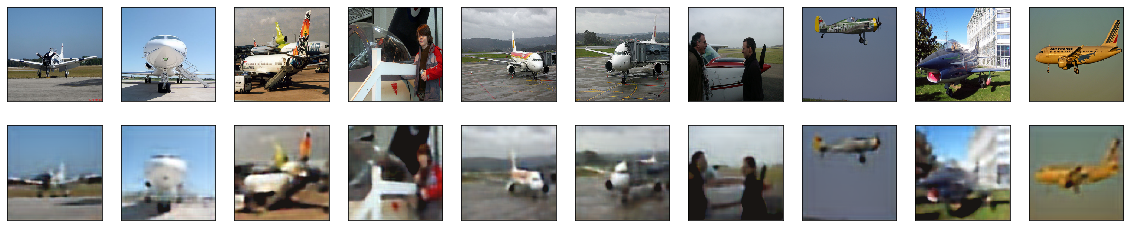

In [10]:
decoded_imgs = autoencoder.predict(x_val)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(image_size, image_size,3)) 
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(image_size, image_size,3) )
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

{'val_loss': [0.7720381267075707, 0.6799220757454819, 0.5254087689377013, 0.3845853804924967, 0.3449452409277792, 0.1999796224183424, 0.17389881410337135, 0.11949228486104041, 0.08776758213220916, 0.057920962448692714, 0.04256176845195624, 0.03273936069144349, 0.0242437744786959, 0.012518561287063867, 0.009889656791606182, 0.00891218800097704, 0.0074640991278069856, 0.006973608288967955, 0.007033330949474566, 0.007598967708870923, 0.006824732906576516, 0.007034505062831053, 0.007508505533948756, 0.006811025023159588, 0.00695698382332921, 0.006801839014534562, 0.006736129068231546, 0.006691097753319126, 0.007333627982955912, 0.007010299735557959, 0.007339055419515811, 0.006921317762893858, 0.006415006167623629, 0.007259424102895625, 0.006976359268345756, 0.006420391871098344, 0.007082050778048873, 0.006705052265608163, 0.006375671609248928, 0.006482259361709682, 0.006431369057916274, 0.006631646809548016, 0.0064493637449083, 0.006323010638533603, 0.006711762194091735, 0.0109914135685340

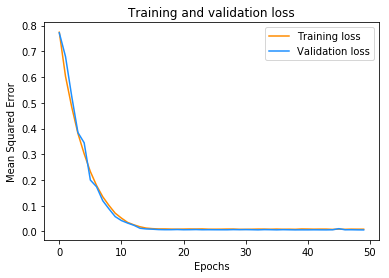

In [11]:
print(autoencoder.history.history)
loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'darkorange', label='Training loss')
plt.plot(epochs, val_loss, 'dodgerblue', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel("Mean Squared Error")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [15]:
np.max(decoded_imgs)

1.465262

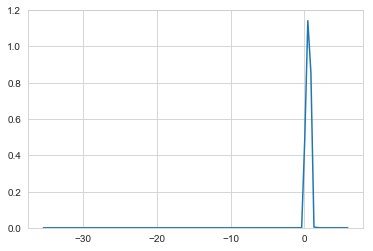

In [51]:
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(decoded_imgs.flatten(), bw='scott' )

0.005047742213110335
479342
94961664


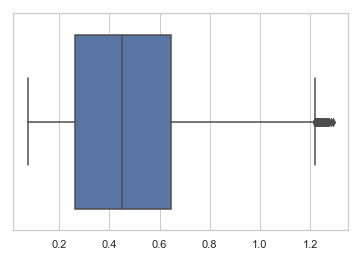

In [12]:
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")

ax = sns.boxplot(x=decoded_imgs.flatten())

aaa=pd.DataFrame(decoded_imgs.flatten(),columns=["pixel"])
s1=aaa.shape[0]
bbb=aaa[(aaa["pixel"]>=0) |  (aaa["pixel"]<=1)]
s2=aaa[(aaa["pixel"]>1) |  (aaa["pixel"]<0)].shape[0]
print(s2/s1)
#sns.kdeplot(bbb["pixel"], bw=0.1 , cut=0)
print(s2)
print(s1)

In [13]:
encoded_imgs = encoder.predict(x_val)
print(encoded_imgs.shape)
encoded_imgs = encoded_imgs.reshape((len(encoded_imgs), np.prod(encoded_imgs.shape[1:])))
print(encoded_imgs.shape)

(483, 16, 16, 300)
(483, 76800)


In [15]:
y_val2=y_val[:,0]
y_val2 #Get Labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123


def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

t-SNE done! Time elapsed: 40.93775153160095 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(-1.223753, -3.9939482, '0'), Text(2.9016795, 6.0413733, '1')])

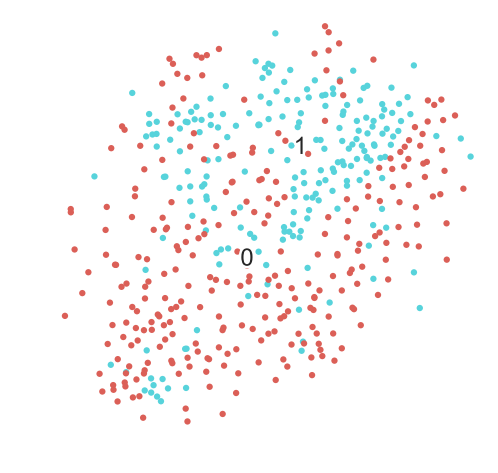

In [16]:

from sklearn.manifold import TSNE
import time
time_start = time.time()
fashion_tsne = TSNE(random_state=42).fit_transform(encoded_imgs)

print( 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
fashion_scatter(fashion_tsne, y_val2)

In [9]:
from keras.models import load_model
encoder = load_model('AutoEncoder2_PASCAL_Deep_weights.50-0.01-0.01.hdf5')
#model.summary()
# for i in range(12):
#     encoder.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
encoder.summary()
#encoder=model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
__________

In [10]:
for layer in encoder.layers:
    layer.trainable = False

In [13]:
encoder.layers[-13]

In [15]:
#model = Sequential()
from keras.regularizers import L1L2
from keras.regularizers import l1
from keras.layers import Flatten
flat=Flatten()(encoder.layers[-13].output)

fully=Dense(2,  # output dim is 2, one score per each class
                activation='softmax',
                kernel_regularizer=l1(0.0001))(flat)  # input dimension = number of features your data has
modelClass = Model(inputs=encoder.input, outputs=fully)
modelClass.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
es_cb = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='auto')
chkpt = './classifierFineTunning_PASCAL_Deep_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
modelClass.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val),callbacks=[es_cb,cp_cb])

Train on 467 samples, validate on 483 samples
Epoch 1/50
467/467 [==============================] - 4s 9ms/step - loss: 2.6875 - acc: 0.7816 - val_loss: 2.0603 - val_acc: 0.8634

Epoch 00001: val_acc improved from -inf to 0.86335, saving model to ./classifierFineTunning_PASCAL_Deep_weights.01-2.69-2.06.hdf5
Epoch 2/50
467/467 [==============================] - 4s 8ms/step - loss: 1.7829 - acc: 0.8801 - val_loss: 2.1636 - val_acc: 0.8468

Epoch 00002: val_acc did not improve from 0.86335
Epoch 3/50
467/467 [==============================] - 4s 8ms/step - loss: 1.5259 - acc: 0.8844 - val_loss: 1.9564 - val_acc: 0.8758

Epoch 00003: val_acc improved from 0.86335 to 0.87578, saving model to ./classifierFineTunning_PASCAL_Deep_weights.03-1.53-1.96.hdf5
Epoch 4/50
467/467 [==============================] - 4s 8ms/step - loss: 1.5683 - acc: 0.9015 - val_loss: 2.1359 - val_acc: 0.8530

Epoch 00004: val_acc did not improve from 0.87578
Epoch 5/50
467/467 [==============================] - 4s 8m

In [18]:
from keras.regularizers import L1L2
from keras.layers import Flatten
flat=Flatten()(encoder.layers[-13].output)
for layer in encoder.layers:
    layer.trainable = True
fully=Dense(2,  # output dim is 2, one score per each class
                activation='softmax',
                kernel_regularizer=l1(0.0001))(flat)  # input dimension = number of features your data has
modelClass = Model(inputs=encoder.input, outputs=fully)
modelClass.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
es_cb = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='auto')
chkpt = './classifierRetrain_PASCAL_Deep_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
modelClass.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val),callbacks=[es_cb,cp_cb])

Train on 467 samples, validate on 483 samples
Epoch 1/50
467/467 [==============================] - 8s 18ms/step - loss: 3.8522 - acc: 0.7088 - val_loss: 2.8071 - val_acc: 0.8116

Epoch 00001: val_acc improved from -inf to 0.81159, saving model to ./classifierRetrain_PASCAL_Deep_weights.01-3.85-2.81.hdf5
Epoch 2/50
467/467 [==============================] - 7s 14ms/step - loss: 2.6057 - acc: 0.8266 - val_loss: 2.7222 - val_acc: 0.8157

Epoch 00002: val_acc improved from 0.81159 to 0.81573, saving model to ./classifierRetrain_PASCAL_Deep_weights.02-2.61-2.72.hdf5
Epoch 3/50
467/467 [==============================] - 7s 14ms/step - loss: 2.3068 - acc: 0.8458 - val_loss: 3.3252 - val_acc: 0.7805

Epoch 00003: val_acc did not improve from 0.81573
Epoch 4/50
467/467 [==============================] - 7s 14ms/step - loss: 1.9715 - acc: 0.8672 - val_loss: 2.7291 - val_acc: 0.8178

Epoch 00004: val_acc improved from 0.81573 to 0.81781, saving model to ./classifierRetrain_PASCAL_Deep_weights.04

In [19]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

for layer in encoder.layers:
    layer.trainable = True

reset_weights(encoder)

from keras.regularizers import L1L2
from keras.layers import Flatten
flat=Flatten()(encoder.layers[-13].output)

fully=Dense(2,  # output dim is 2, one score per each class
                activation='softmax',
                kernel_regularizer=l1(0.0001))(flat)  # input dimension = number of features your data has
modelClass = Model(inputs=encoder.input, outputs=fully)
modelClass.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


chkpt = './classifierRamdom_PASCAL_Deep_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
modelClass.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val),callbacks=[es_cb,cp_cb])

Train on 467 samples, validate on 483 samples
Epoch 1/50
467/467 [==============================] - 7s 16ms/step - loss: 5.0498 - acc: 0.6424 - val_loss: 6.8697 - val_acc: 0.5611

Epoch 00001: val_acc improved from -inf to 0.56108, saving model to ./classifierRamdom_PASCAL_Deep_weights.01-5.05-6.87.hdf5
Epoch 2/50
467/467 [==============================] - 7s 14ms/step - loss: 2.8983 - acc: 0.8051 - val_loss: 5.6523 - val_acc: 0.6460

Epoch 00002: val_acc improved from 0.56108 to 0.64596, saving model to ./classifierRamdom_PASCAL_Deep_weights.02-2.90-5.65.hdf5
Epoch 3/50
467/467 [==============================] - 7s 14ms/step - loss: 1.9178 - acc: 0.8651 - val_loss: 2.5392 - val_acc: 0.8302

Epoch 00003: val_acc improved from 0.64596 to 0.83023, saving model to ./classifierRamdom_PASCAL_Deep_weights.03-1.92-2.54.hdf5
Epoch 4/50
467/467 [==============================] - 7s 14ms/step - loss: 1.7033 - acc: 0.8887 - val_loss: 4.7234 - val_acc: 0.7039

Epoch 00004: val_acc did not improve 

(483, 16, 16, 300)
(483, 76800)
t-SNE done! Time elapsed: 36.356356620788574 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(3.3689537, -2.708327, '0'), Text(-3.1181965, 5.208045, '1')])

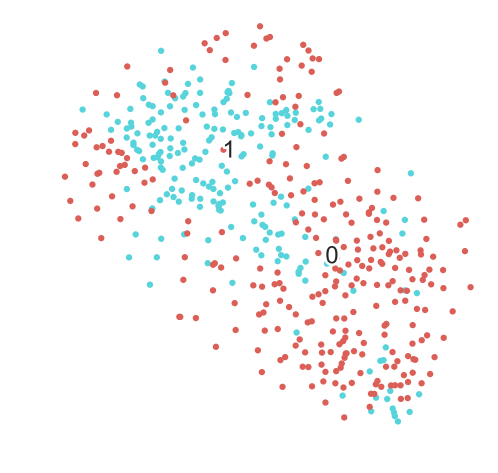

In [16]:
from sklearn.manifold import TSNE
import time
time_start = time.time()
encoded_imgs = encoder.predict(x_val)
print(encoded_imgs.shape)
encoded_imgs = encoded_imgs.reshape((len(encoded_imgs), np.prod(encoded_imgs.shape[1:])))
print(encoded_imgs.shape)


time_start = time.time()
fashion_tsne = TSNE(random_state=42).fit_transform(encoded_imgs)

print( 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
fashion_scatter(fashion_tsne, y_val2)



In [29]:
print(modelClass.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       9728      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 256)         0         
__________

In [25]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from skimage.io import imread, imshow, concatenate_images
from keras.layers.merge import concatenate, add



def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

input_img = Input(shape=(image_size, image_size, 3))
n_filters=16 
dropout=0.05
batchnorm=True
# contracting path
c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(dropout*0.5)(p1)

c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(dropout)(p2)

c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(dropout)(p3)

c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(dropout)(p4)

c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

# expansive path
u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
u6 = Dropout(dropout)(u6)
c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = Dropout(dropout)(u7)
c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = Dropout(dropout)(u8)
c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = Dropout(dropout)(u9)
c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
model = Model(inputs=[input_img], outputs=[outputs])


model.compile(optimizer='adadelta', loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 256, 256, 16) 64          conv2d_78[0][0]                  
__________________________________________________________________________________________________
activation_70 (Activation)      (None, 256, 256, 16) 0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
conv2d_79 

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
results = model.fit(x_train, y_train, batch_size=10, epochs=100, callbacks=callbacks,
                    validation_data=(x_val, y_val))

ValueError: Error when checking target: expected conv2d_96 to have 4 dimensions, but got array with shape (467, 2)